In [1]:
from os.path import dirname
import os
import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
%load_ext autoreload
%autoreload 2
import brandear_est as be

In [4]:
MIMIC_DIR = os.path.join(os.getcwd(), "../../data/mimic/")
INPUT_DIR = os.path.join(os.getcwd(), "../../data/input/")
IMD_DIR = os.path.join(os.getcwd(), "../../data/intermediate/")
SUBMIT_DIR = os.path.join(os.getcwd(), "../../data/submit/")

dset_to_period = {
    "train": {"oldest": datetime.datetime(2019, 9, 3, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 10, 0, 0, 0)},
    "valid_for_train": {"oldest": datetime.datetime(2019, 9, 10, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 17, 0, 0, 0),},    
    "valid_for_sub": {"oldest": datetime.datetime(2019, 9, 17, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 24, 0, 0, 0),},
    "submission": {"oldest": datetime.datetime(2019, 9, 24, 0, 0, 0),
              "newest": datetime.datetime(2019, 10, 1, 0, 0, 0),},    
}

In [5]:
# 元データ読み込み
auction= pd.read_pickle(IMD_DIR + "202001171749" + "_auction.pkl")
watch= pd.read_pickle(IMD_DIR + "202001171749" + "_watch.pkl")
bid= pd.read_pickle(IMD_DIR + "202001171749" + "_bid.pkl")
bid_success= pd.read_pickle(IMD_DIR + "202001171749" + "_bid_success.pkl")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")    

sub_users = sample_sub[["KaiinID"]].drop_duplicates()


In [6]:
# 特徴量計算対象データセット作成
train_dataset_base= pd.read_pickle(IMD_DIR + "202001201749" + "_train_dataset_base.pkl")
vt_dataset_base= pd.read_pickle(IMD_DIR + "202001201749" + "_vt_dataset_base.pkl")
vs_dataset_base= pd.read_pickle(IMD_DIR + "202001201749" + "_vs_dataset_base.pkl")
sub_dataset_base= pd.read_pickle(IMD_DIR + "202001201749" + "_sub_dataset_base.pkl") 

In [7]:
# 特徴量計算
#     train_dataset = pd.read_pickle(IMD_DIR + "202001201925" + "_train_dataset.pkl")
vt_dataset = pd.read_pickle(IMD_DIR + "202001211552" + "_vt_dataset.pkl")
vs_dataset = pd.read_pickle(IMD_DIR + "202001211552" + "_vs_dataset.pkl")
sub_dataset = pd.read_pickle(IMD_DIR + "202001211552" + "_sub_dataset.pkl") 

In [117]:
vt_dataset_base.head()

,KaiinID,AuctionID,watch_actioned,bid_actioned
0,53,1819,0.0,0.0
1,53,2927,0.0,0.0
2,53,3786,0.0,0.0
3,53,4282,0.0,0.0
4,53,6614,0.0,0.0


In [8]:
watch_auc = watch.merge(auction, on="AuctionID", how="inner")

In [9]:
target_actions = be.extract_target_actions(watch, bid, dset_to_period["valid_for_sub"])
target_users = target_actions[["KaiinID"]].drop_duplicates()

In [10]:
valid_aucs = be.extract_valid_aucs(auction, watch, bid_success, dset_to_period["valid_for_sub"])

In [11]:
def get_mode_pairs(watch_auc, target_users, valid_aucs, key):
    user_modes= (
        watch_auc.merge(target_users, on=["KaiinID"], how="inner")[["KaiinID", key]]
        .groupby(["KaiinID", key], as_index=False).size().unstack().idxmax(1).reset_index()
        .rename(columns={0: key})
    )
    mode_pairs = (
        auction[[key, "AuctionID"]].merge(valid_aucs, on="AuctionID", how="inner")
        .merge(user_modes, on=key, how="inner")
    )
    return mode_pairs

In [52]:
def get_user_mode(watch_auc, target_users, key):
    user_modes= (
        watch_auc.merge(target_users, on=["KaiinID"], how="inner")[["KaiinID", key]]
        .groupby(["KaiinID", key], as_index=False).size().unstack().idxmax(1).reset_index()
        .rename(columns={0: key})
    )
    return user_modes

In [111]:
watch_auc.groupby(["KaiinID", "BrandID"], as_index=False).size().reset_index().rename(columns={0: key})

,KaiinID,BrandID,LineID
0,22,10,2
1,22,12,28
2,22,19,3
3,22,30,2
4,22,47,21
...,...,...,...
776810,277891,10326,1
776811,277891,10364,1
776812,277891,10438,20
776813,277891,10594,7


In [36]:
mode_pairs = get_mode_pairs(watch_auc, target_users, valid_aucs, "BrandID")

In [37]:
print(mode_pairs.shape)
print(mode_pairs.merge(target_actions, on=["KaiinID", "AuctionID"], how="inner").shape)

(41191423, 3)
(21200, 5)


,AuctionID
0,4066465
1,622037
2,3447030
3,957658
5,1242382
...,...
816273,3636243
816274,2927568
816275,976663
816276,739919


In [86]:
brand_mode = get_user_mode(watch_auc, target_users, "BrandID")
gend_mode = get_user_mode(watch_auc, target_users, "DanjobetsuID")
color_mode = get_user_mode(watch_auc, target_users, "ColorID")
geng_mode = get_user_mode(watch_auc, target_users, "GenreGroupID") 
gen_mode = get_user_mode(watch_auc, target_users, "GenreID") 
con_mode = get_user_mode(watch_auc, target_users, "ConditionID") 

In [87]:
q_df = pd.concat([
    brand_mode,
    gend_mode.drop("KaiinID", axis=1),
    color_mode.drop("KaiinID", axis=1), 
    geng_mode.drop("KaiinID", axis=1),
    gen_mode.drop("KaiinID", axis=1),
    con_mode.drop("KaiinID", axis=1)], axis=1)

In [93]:
q_re = q_df.merge(
    auction.merge(valid_aucs, on="AuctionID", how="inner"),
    on=["DanjobetsuID", "ColorID", "GenreGroupID", "GenreID", "ConditionID"], how="inner")

In [94]:
q_re.head()

,KaiinID,BrandID_x,DanjobetsuID,ColorID,GenreGroupID,GenreID,ConditionID,AuctionID,ShouhinShubetsuID,ShouhinID,SaishuppinKaisuu,BrandID_y,LineID,SankouKakaku,CreateDate
0,22,12,0,0,312,321,6,4079311,1,1132159,0,1011,0,1000,2019-07-27 09:31:45
1,22,12,0,0,312,321,6,3036982,1,2651629,334,1,0,10000,2019-07-27 09:31:48
2,22,12,0,0,312,321,6,3747358,1,1171525,0,32,0,2500,2019-07-27 09:31:48
3,22,12,0,0,312,321,6,442922,1,1282599,0,119,0,5000,2019-07-27 09:32:09
4,22,12,0,0,312,321,6,813198,1,640133,0,2479,0,6000,2019-07-27 09:32:13


In [95]:
print(q_re.shape)
print(q_re[["KaiinID", "AuctionID"]].merge(target_actions, on=["KaiinID", "AuctionID"], how="inner").shape)

(35518961, 15)
(5960, 4)


In [96]:
valid_aucs.shape

(751419, 1)

(array([151.,  10.,   5.,   2.,   3.,   3.,   0.,   3.,   0.,   2.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.00000e+00, 1.62500e+01, 3.15000e+01, 4.67500e+01, 6.20000e+01,
        7.72500e+01, 9.25000e+01, 1.07750e+02, 1.23000e+02, 1.38250e+02,
        1.53500e+02, 1.68750e+02, 1.84000e+02, 1.99250e+02, 2.14500e+02,
        2.29750e+02, 2.45000e+02, 2.60250e+02, 2.75500e+02, 2.90750e+02,
        3.06000e+02, 3.212

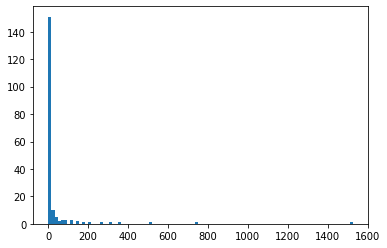

In [104]:
plt.hist(target_actions[["KaiinID", "AuctionID"]].groupby("KaiinID").count()["AuctionID"].value_counts(), bins=100)

In [107]:
dataset = add_value_counts(
    dataset=dataset,
    feature_df=watch_auc,
    colsets=col_sets,
    prefix="watch",
    oldest_dtime=period["oldest"],
    time_col="TourokuDate"
)

NameError: name 'dataset' is not defined

In [115]:
def get_value_counts(feature_df, colset, prefix, oldest_dtime, time_col):
    feature_valid = feature_df[feature_df[time_col] < oldest_dtime]
    if len(colset) == 2:
        cnts = (
            feature_df.groupby(colset, as_index=False).size().reset_index()
            .rename(columns={0: f"{prefix}_{colset[0]}_{colset[1]}_cnt"})
        )
    elif len(colset) == 1:
        col = colset[0]
        cnts = (
            feature_valid[col].value_counts().reset_index()
            .rename(columns={"index": col, col: f"{prefix}_{col}_cnt"})
        )
    return cnts

In [ ]:
for colset in colsets
    be.to_pickle(FEATURE)

In [116]:
get_value_counts(watch_auc, ["KaiinID", "BrandID"], "watch", dset_to_period["valid_for_sub"]["oldest"], "TourokuDate")

,KaiinID,BrandID,watch_KaiinID_BrandID_cnt
0,22,10,2
1,22,12,28
2,22,19,3
3,22,30,2
4,22,47,21
...,...,...,...
776810,277891,10326,1
776811,277891,10364,1
776812,277891,10438,20
776813,277891,10594,7
